<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/NARXModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Necessary imports to configure the environment.

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

Getting the Dataset from the Github repository:

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

The Hysteresis Dataset is downloaded from the Github repository and stored into a dictionary. Each DataFrame is normalized between -1 and 1

In [3]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = False

# The scaler is used to rescale the dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset 
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B']) 
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

Roll the signals to let them start from the Saturation value (rolling back $1/4$ of a period)

In [4]:
# Set the flag to True to let the signals start from the saturation point
start_from_sat = True

if start_from_sat:
    for freq in dataset:
        dataset[freq] = dataset[freq].reindex(np.roll(dataset[freq].index, -len(dataset[freq])//4))

Repeat the signals for a fixed number of times and resample them to a new `resample_fs` (audio sampling frequency: $48 kHz, 96 kHz$)

In [5]:
import scipy as sp
"""
This method is used to resample the DataFrame signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:columns: columns of the Dataframe to resample
:param repetitions: if greater than one, the represented curve period is repeated
multiple times
:param resample_fs: frequency to resample the signal to
:param fs: starting sampling frequency
:return: dictionary containing the resampled curves indexed by frequency
"""
def resample_dataset(data, columns, repetitions, resample_fs, fs):
    resampled_dataset = collections.OrderedDict()
    
    for freq in data:
        num_sample = len(data[freq]) * repetitions
        num_sample_sub = int(num_sample / fs * resample_fs)

        resampled_dataset[freq] = pd.DataFrame(sp.signal.resample(np.tile(data[freq], (repetitions, 1)), num_sample_sub), columns=columns)

    return resampled_dataset

In [6]:
# Resample the dataset signals:
fs = 1e5
resample_fs = 96e3 # or 44.1e3, 48e3, 96e3

repetitions = 2
dataset = resample_dataset(data=dataset, columns=['H', 'B'], repetitions=repetitions, resample_fs=resample_fs, fs=fs)

Building the *Training Set*. The median frequency curve (H at 20 Hz) is excluded from training and used for validation purposes.

In [7]:
train_dataset = collections.OrderedDict()

for freq in dataset:
    if freq != 'P2_20Hz.CSV':
        train_dataset[freq] = dataset[freq]

Building the *Validation Set*. It includes the 20 Hz curve.

In [8]:
val_dataset = collections.OrderedDict()

for freq in dataset:
    if freq == 'P2_20Hz.CSV':
        val_dataset[freq] = dataset[freq]

# NARX Model Training:
This notebook contains the preliminary tests: different strategies to train the NARX are here explored, trying to understand how to proceed.

In [9]:
# Defining some of the Network and Sequence parameters:
# For training purposes, the sequence length is fixed to 20
seq_len = 20
n_train_signals = len(train_dataset)

The WindowGenerator Class can:

1. Handle the indexes and offsets.
2. Split windows of features into (features, labels) pairs.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Datasets`.

The following code is inspired from https://www.tensorflow.org/tutorials/structured_data/time_series

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               label_columns=None, feature_columns=None, columns=None, 
               sequence_stride=1, batch_size=1):

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_column_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.feature_columns = feature_columns
        self.column_indices = {name: i for i, name in
                           enumerate(columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # This customization allows to select the features to use as input, by properly setting
        # the feature_columns argument   
        if self.feature_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.feature_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=self.sequence_stride,
                shuffle=False,
                batch_size=self.batch_size)

        ds = ds.map(self.split_window)

        return ds

The window extracts sequences spaced one sample:
```
[[sample[t0], sample[t1], ... sample[t_seq_len]], [sample[t1], sample[t2], ..., sample[t_seq_len + 1]], ...]

```

In [ ]:
# Setting the batch generation parameters
seq_per_signal = 4

# Setting the Window Generator parameters
win_batch_size = 1 # Internal batch_size for the Window Generator
sequence_stride = 1 # Sample distance between successive sequences
seq_len = 20 # The length of the Input Sequence
label_width = seq_len # The length of the Label Sequence

# Instantiating a window class
sequence_window = WindowGenerator(
    input_width=seq_len, label_width=label_width, shift=0,
    label_columns=['B'], feature_columns=['H'], columns=['H', 'B'],
    sequence_stride=sequence_stride, batch_size=win_batch_size)

sequence_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label column name(s): ['B']

## Training Set

In [ ]:
x_data_list = []
y_data_list = []

def get_x_data(features, labels):
    return (tf.squeeze(features, axis=0), tf.squeeze(labels[:, :-1, :], axis=0))

def get_y_data(features, labels):
    return tf.squeeze(labels[:, -1, :], axis=0)

def concat(*ds_elements):
    if type(ds_elements[0]) is tuple:
        #Create one empty list for each component of the dataset
        lists = [[] for _ in ds_elements[0]]
        for element in ds_elements:
            for i, tensor in enumerate(element):
                #For each element, add all its component to the associated list
                lists[i].append(tensor)
                #Concatenate each component list
        return tuple(tf.concat(l, axis=0) for l in lists)
    else:
        return tf.concat(ds_elements, axis=0)

for freq in train_dataset:
    x_data_list.append(sequence_window.make_dataset(train_dataset[freq])
            .map(get_x_data)
            .shuffle(buffer_size=len(train_dataset[freq]), seed=SEED, reshuffle_each_iteration=True)
            .batch(seq_per_signal, drop_remainder=True)
            .repeat())
    y_data_list.append(sequence_window.make_dataset(train_dataset[freq])
            .map(get_y_data)
            .shuffle(buffer_size=len(train_dataset[freq]), seed=SEED, reshuffle_each_iteration=True)
            .batch(seq_per_signal, drop_remainder=True)
            .repeat())

train_x_data = tf.data.Dataset.zip(tuple(x_data_list))
train_x_data = train_x_data.map(concat)

train_y_data = tf.data.Dataset.zip(tuple(y_data_list))
train_y_data = train_y_data.map(concat)

train_data = tf.data.Dataset.zip((train_x_data, train_y_data))

In [ ]:
# Instantiating an iterator over the training dataset
iterator = iter(train_data)  

In [ ]:
features, labels = next(iterator)
print("Features batch:" + str(features))
print("Labels batch:" + str(labels))

## Validation Set

In [ ]:
x_data_list = []
y_data_list = []

def get_x_data(features, labels):
    return (features, labels[:, :-1, :])

def get_y_data(features, labels):
    return labels[:, -1, :]

for freq in val_dataset:
    x_data_list.append(sequence_window.make_dataset(val_dataset[freq]).map(get_x_data))
    y_data_list.append(sequence_window.make_dataset(val_dataset[freq]).map(get_y_data))

val_x_data = tf.data.Dataset.zip(tuple(x_data_list))
val_x_data = val_x_data.map(concat)

val_y_data = tf.data.Dataset.zip(tuple(y_data_list))
val_y_data = val_y_data.map(concat)

val_data = tf.data.Dataset.zip((val_x_data, val_y_data))

In [ ]:
# Instantiating an iterator over the validation dataset
iterator = iter(val_data)  

In [ ]:
features, labels = next(iterator)
print("Features batch:" + str(features))
print("Labels batch:" + str(labels))

In [10]:
"""
This method is used to  batch the signals contained in a dictionary
:param data: dictionary containing the curves indexed by frequency
:param seq_len: it refers to the length of each input sequence in the batch (must
be a common divider of all the curves lengths)
:param stride: it refers to the distance in sample between successive windows
"""
def batch_data(data, seq_len, stride):
    batch_size = len(data)

    num_sample_max = max([x.shape[0] for x in data.values()])
    
    H_set = np.zeros((batch_size, num_sample_max))
    B_set = np.zeros((batch_size, num_sample_max))

    for index, freq in enumerate(data):
        repeat = num_sample_max // len(data[freq])
        H_set[index, :] = np.tile(data[freq]['H'], repeat)
        B_set[index, :] = np.tile(data[freq]['B'], repeat)

    X = []
    Y = []

    for i in range(0, num_sample_max, stride):
        if (i + seq_len) <= num_sample_max:
            X.append(H_set[:, i : i + seq_len])
            Y.append(B_set[:, i : i + seq_len])
    
    return (np.expand_dims(np.array(X), axis=-1), np.expand_dims(np.array(Y), axis=-1))

## Series–Parallel Mode Jordan NARX Network (Jordan-SP)

Building the seq2seq batches

In [ ]:
X_train, y_train = batch_data(data=train_dataset, seq_len=seq_len, stride=1)
X_val, y_val = batch_data(data=val_dataset, seq_len=seq_len, stride=1)

Applying the correct Dataset mapping

In [ ]:
def map_fn(features, labels):
    return ((features, labels[:, :-1, :]), labels[:, -1, :])

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(map_fn)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(map_fn)

Defining the Narx Model (Parallel-Series Architecture)

Model: "NARX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(None, 20)]         0           []                               
                                                                                                  
 y (InputLayer)                 [(None, 19)]         0           []                               
                                                                                                  
 InputLayer (Concatenate)       (None, 39)           0           ['u[0][0]',                      
                                                                  'y[0][0]']                      
                                                                                                  
 Dense_Layer_1 (Dense)          (None, 4)            160         ['InputLayer[0][0]']          

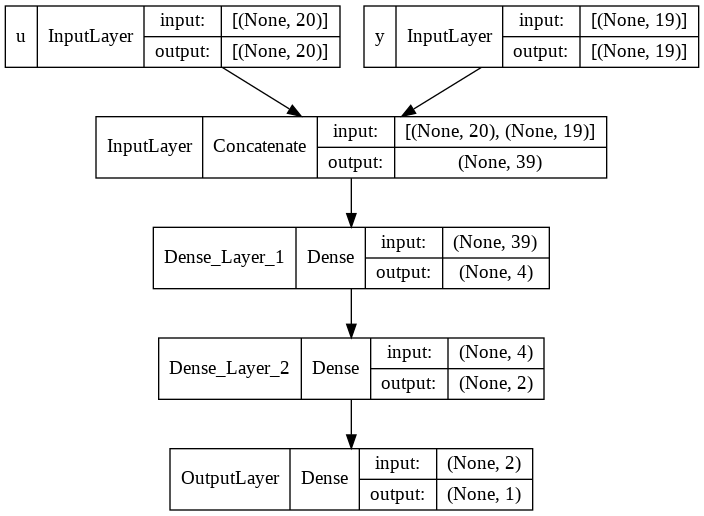

In [ ]:
# Number of previous inputs
K = 20
# Number of previous outputs
H = 20

# Units per layer
A = [4, 2]
# Number of layers
L = len(A)

#train_batch_size = n_train_signals * seq_per_signal
train_batch_size = None

u = tf.keras.layers.Input(shape=(K), batch_size=train_batch_size, name='u')
y = tf.keras.layers.Input(shape=(H-1), batch_size=train_batch_size, name='y')

concatenate = tf.keras.layers.concatenate([u, y], name='InputLayer', axis=-1)

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i], 
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(concatenate)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

model = tf.keras.Model(inputs=[u, y], outputs=outputs, name='NARX')
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [ ]:
# Compile Model
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Set the model's name:

In [ ]:
filename = f'NARX_K={K}_H={H}_layers={L}_neurons={A}.h5'

Setting Early Stop and Model Checkpoint Callbacks:

In [ ]:
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Thesis', 'NARX')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

# Set the name of the model to store the Checkpoints
model_name = filename

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'model.{epoch:02d}-{val_loss:.2e}.h5'),
                                                   save_best_only=True, 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    callbacks.append(es_callback)

### Batch Training:
(`n_train_signals × seq_per_signal` sequences per batch, with `seq_per_signal` sequences for each frequency)

*Series-Parallel Architecture Training*: K input values and (H - 1) output values are used to predict the next output value

In [ ]:
# Training over all the dataset:

# Setting the number of training epochs
num_epochs = 100
# Setting the number of steps per each epoch
# steps_per_epoch = 20000

model.fit(train_data, validation_data=val_data, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
383981/383981 [==============================] - 642s 2ms/step - loss: 0.0187 - mean_absolute_error: 0.0260 - val_loss: 8.4690e-05 - val_mean_absolute_error: 0.0072
Epoch 2/100
383981/383981 [==============================] - 652s 2ms/step - loss: 7.0230e-05 - mean_absolute_error: 0.0057 - val_loss: 4.5128e-05 - val_mean_absolute_error: 0.0053
Epoch 3/100
383981/383981 [==============================] - 644s 2ms/step - loss: 4.5948e-05 - mean_absolute_error: 0.0046 - val_loss: 3.0166e-05 - val_mean_absolute_error: 0.0044
Epoch 4/100
383981/383981 [==============================] - 645s 2ms/step - loss: 3.2368e-05 - mean_absolute_error: 0.0039 - val_loss: 2.2842e-05 - val_mean_absolute_error: 0.0039
Epoch 5/100
383981/383981 [==============================] - 644s 2ms/step - loss: 2.5290e-05 - mean_absolute_error: 0.0035 - val_loss: 1.8307e-05 - val_mean_absolute_error: 0.0034
Epoch 6/100
383981/383981 [==============================] - 642s 2ms/step - loss: 2.1297e-05 - mea

## Parallel Mode Jordan NARX Network (Jordan-P)

Training and Validation Sets:

In [11]:
X_train, y_train = batch_data(data=train_dataset, seq_len=seq_len, stride=1)
X_val, y_val = batch_data(data=val_dataset, seq_len=seq_len, stride=1)

Defining the model parameters:

In [12]:
# Number of previous inputs
K = 20
# Number of previous outputs
H = 20

# Units per layer
A = [8, 8]
# Number of layers
L = len(A)

### Building pre-Jordan-SP Model:

Model: "pre-Jordan-SP-NARX"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 u (InputLayer)              [(None, 20)]              0         
                                                                 
 Dense_Layer_1 (Dense)       (None, 8)                 168       
                                                                 
 Dense_Layer_2 (Dense)       (None, 8)                 72        
                                                                 
 OutputLayer (Dense)         (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


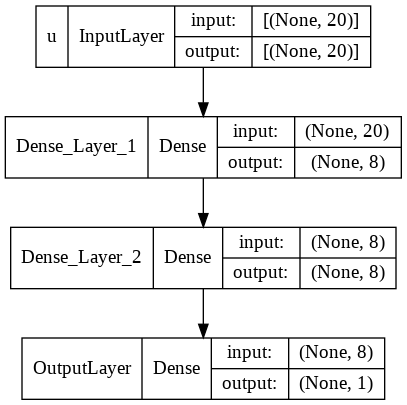

In [ ]:
train_batch_size = None

u = tf.keras.layers.Input(shape=(K), batch_size=train_batch_size, name='u')

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i], 
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(u)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

pre_jordan_SP_model = tf.keras.Model(inputs=u, outputs=outputs, name='pre-Jordan-SP-NARX')
pre_jordan_SP_model.summary()

tf.keras.utils.plot_model(pre_jordan_SP_model, show_shapes=True)

Building the training batches for the pre-Jordan-SP Model:

In [ ]:
def pre_jordan_SP_map_fn(features, labels):
    return (features, labels[:, -1, :])

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(pre_jordan_SP_map_fn)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(pre_jordan_SP_map_fn)

In [ ]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [ ]:
# Compile Model
pre_jordan_SP_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Set the model's name:

In [ ]:
filename = f'pre-Jordan-SP_K={K}_H={H}_layers={L}_neurons={A}.h5'

Setting Early Stop and Model Checkpoint Callbacks:

In [ ]:
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Thesis/NARX', 'pre-Jordan-SP')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

# Set the name of the model to store the Checkpoints
model_name = filename

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'model.{epoch:02d}-{val_loss:.2e}.h5'),
                                                   save_best_only=True, 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    callbacks.append(es_callback)

In [ ]:
# Setting the number of training epochs
num_epochs = 100

pre_jordan_SP_model.fit(train_data, validation_data=val_data, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
383981/383981 [==============================] - 519s 1ms/step - loss: 0.0043 - mean_absolute_error: 0.0324 - val_loss: 0.0060 - val_mean_absolute_error: 0.0419
Epoch 2/100
383981/383981 [==============================] - 513s 1ms/step - loss: 9.4433e-04 - mean_absolute_error: 0.0184 - val_loss: 0.0031 - val_mean_absolute_error: 0.0343
Epoch 3/100
383981/383981 [==============================] - 515s 1ms/step - loss: 8.1057e-04 - mean_absolute_error: 0.0173 - val_loss: 0.0036 - val_mean_absolute_error: 0.0335
Epoch 4/100
383981/383981 [==============================] - 509s 1ms/step - loss: 7.2858e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0043 - val_mean_absolute_error: 0.0334
Epoch 5/100
383981/383981 [==============================] - 508s 1ms/step - loss: 6.6819e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0053 - val_mean_absolute_error: 0.0338


In [ ]:
# Saving the model weights
pre_jordan_SP_model.save_weights(filename, save_format='h5')

### Building Jordan-SP Model:

Model: "Jordan-SP-NARX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(None, 20)]         0           []                               
                                                                                                  
 y (InputLayer)                 [(None, 19)]         0           []                               
                                                                                                  
 InputLayer (Concatenate)       (None, 39)           0           ['u[0][0]',                      
                                                                  'y[0][0]']                      
                                                                                                  
 Dense_Layer_1 (Dense)          (None, 8)            320         ['InputLayer[0][0]']

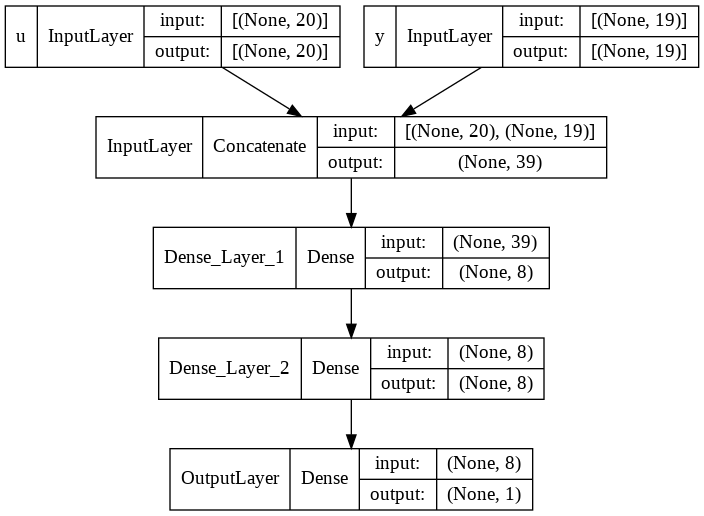

In [ ]:
train_batch_size = None

u = tf.keras.layers.Input(shape=(K), batch_size=train_batch_size, name='u')
y = tf.keras.layers.Input(shape=(H-1), batch_size=train_batch_size, name='y')

concatenate = tf.keras.layers.concatenate([u, y], name='InputLayer', axis=-1)

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i], 
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(concatenate)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

jordan_SP_model = tf.keras.Model(inputs=[u, y], outputs=outputs, name='Jordan-SP-NARX')
jordan_SP_model.summary()

tf.keras.utils.plot_model(jordan_SP_model, show_shapes=True)

Building the training batches for the Jordan-SP Model:

In [17]:
def jordan_SP_map_fn(features, labels):
    return ((features, labels[:, :-1, :]), labels[:, -1, :])

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(jordan_SP_map_fn)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(jordan_SP_map_fn)

Initializing the Jordan-SP Model weights using the already trained pre-Jordan-SP Model weights:

In [ ]:
pre_jordan_SP_weights = pre_jordan_SP_model.get_layer(name="Dense_Layer_1").get_weights()
jordan_SP_weights = jordan_SP_model.get_layer(name="Dense_Layer_1").get_weights()

jordan_SP_weights[0][:20, :] = pre_jordan_SP_weights[0]
jordan_SP_weights[1] = pre_jordan_SP_weights[1]

jordan_SP_model.load_weights(filename, by_name=True, skip_mismatch=True)
jordan_SP_model.get_layer(name="Dense_Layer_1").set_weights(jordan_SP_weights)

In [ ]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [ ]:
# Compile Model
jordan_SP_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Set the model's name:

In [ ]:
filename = f'Jordan-SP_K={K}_H={H}_layers={L}_neurons={A}.h5'

Setting Early Stop and Model Checkpoint Callbacks:

In [ ]:
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Thesis/NARX', 'Jordan-SP')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

# Set the name of the model to store the Checkpoints
model_name = filename

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir,'model.{epoch:02d}-{val_loss:.2e}.h5'),
                                                   save_best_only=True, 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    callbacks.append(es_callback)

In [ ]:
# Setting the number of training epochs
num_epochs = 100

jordan_SP_model.fit(train_data, validation_data=val_data, epochs=num_epochs, callbacks=callbacks)

Epoch 1/100
383981/383981 [==============================] - 550s 1ms/step - loss: 7.6123e-05 - mean_absolute_error: 0.0058 - val_loss: 1.6136e-04 - val_mean_absolute_error: 0.0089
Epoch 2/100
383981/383981 [==============================] - 536s 1ms/step - loss: 2.0103e-05 - mean_absolute_error: 0.0029 - val_loss: 4.8508e-05 - val_mean_absolute_error: 0.0042
Epoch 3/100
383981/383981 [==============================] - 549s 1ms/step - loss: 1.9555e-05 - mean_absolute_error: 0.0028 - val_loss: 2.7981e-05 - val_mean_absolute_error: 0.0032
Epoch 4/100
383981/383981 [==============================] - 547s 1ms/step - loss: 1.3739e-05 - mean_absolute_error: 0.0024 - val_loss: 1.7892e-05 - val_mean_absolute_error: 0.0021
Epoch 5/100
383981/383981 [==============================] - 543s 1ms/step - loss: 9.9212e-06 - mean_absolute_error: 0.0021 - val_loss: 1.5324e-05 - val_mean_absolute_error: 0.0024
Epoch 6/100
383981/383981 [==============================] - 544s 1ms/step - loss: 7.6732e-06 -

In [ ]:
# Saving the model weights
jordan_SP_model.save_weights(filename, save_format='h5')

### Building Jordan-P Model:

Model: "Jordan-P-NARX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(None, 20)]         0           []                               
                                                                                                  
 y (InputLayer)                 [(None, 19)]         0           []                               
                                                                                                  
 InputLayer (Concatenate)       (None, 39)           0           ['u[0][0]',                      
                                                                  'y[0][0]']                      
                                                                                                  
 Dense_Layer_1 (Dense)          (None, 8)            320         ['InputLayer[0][0]'] 

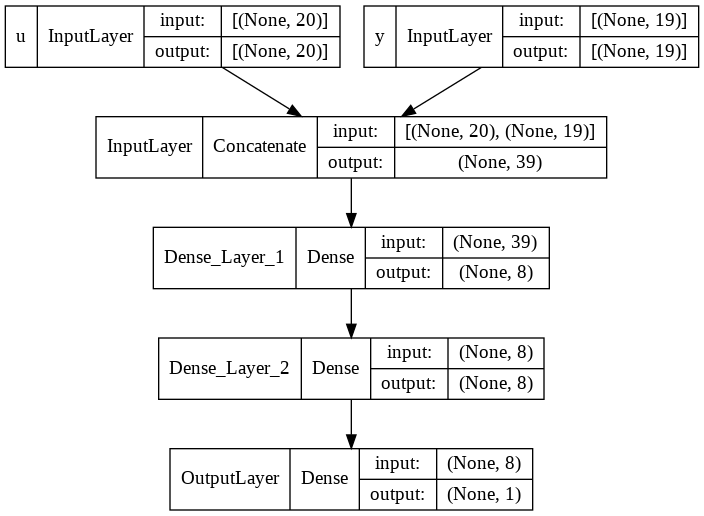

In [14]:
train_batch_size = None

u = tf.keras.layers.Input(shape=(K), batch_size=train_batch_size, name='u')
y = tf.keras.layers.Input(shape=(H-1), batch_size=train_batch_size, name='y')

concatenate = tf.keras.layers.concatenate([u, y], name='InputLayer', axis=-1)

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i], 
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(concatenate)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

jordan_P_model = tf.keras.Model(inputs=[u, y], outputs=outputs, name='Jordan-P-NARX')
jordan_P_model.summary()

tf.keras.utils.plot_model(jordan_P_model, show_shapes=True)

Building the training batches for the pre-Jordan-SP Model:

In [15]:
def jordan_P_map_fn(features, labels):
    return (features, labels[:, -1, :])

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(jordan_P_map_fn)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(jordan_P_map_fn)

Initializing the Jordan-P Model weights using the already trained Jordan-SP Model weights:

In [17]:
jordan_P_model.load_weights(filename, by_name=True, skip_mismatch=True)

In [21]:
# Optimization parameters

# Mean Squared Error for Regression
loss = tf.keras.losses.MSE 
# Learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [tf.metrics.MeanAbsoluteError()]

In [22]:
# Compile Model
jordan_P_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Set the model's name:

In [23]:
filename = f'Jordan-P_K={K}_H={H}_layers={L}_neurons={A}.h5'

In [24]:
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/Thesis/NARX', 'Jordan-P')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

# Set the name of the model to store the Checkpoints
model_name = filename

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)   

In [25]:
# Setting the number of training epochs
num_epochs = 10

tr_batch_size = 10
val_batch_size = 1

training_history = {}
validation_history = {}

for epoch in range(2, num_epochs):
    mean_train_loss = []
    mean_train_mae = []

    # Circular buffer containing the model predictions
    d_train = np.zeros((tr_batch_size, H - 1))
    d_train = y_train[0, :, :-1]
    d_val = np.zeros((val_batch_size, H - 1))
    d_val = y_val[0, :, :-1]

    print('Epoch:' + ' ' + str(epoch+1))
    print('Training...')
    for u, y in train_data:
        train_prediction = jordan_P_model.predict_on_batch(x=[u, d_train])

        train_loss, train_mae = jordan_P_model.train_on_batch(x=[u, d_train], y=y)

        mean_train_loss.append(train_loss)
        mean_train_mae.append(train_mae)

        d_train[:, :-1] = d_train[:, 1:]
        d_train[:, -1] = train_prediction

    training_history[epoch] = np.mean(mean_train_loss)

    print('training loss  = {:.2e}'.format(training_history[epoch]))
    print('training mae = {:.2e}'.format(np.mean(mean_train_mae)))
    print('___________________________________')


    mean_val_loss = []
    mean_val_mae = []
    print('Validation...')
    for u, y in val_data:
        val_loss, val_mae = jordan_P_model.test_on_batch(x=[u, d_val], y=y)

        mean_val_loss.append(val_loss)
        mean_val_mae.append(val_mae)

        val_prediction = jordan_P_model.predict_on_batch(x=[u, d_val])

        d_val[:, :-1] = d_val[:, 1:]
        d_val[:, -1] = val_prediction

    validation_history[epoch] = np.mean(mean_val_loss)

    print('val loss  = {:.2e}'.format(validation_history[epoch]))
    print('val mae = {:.2e}'.format(np.mean(mean_val_mae)))
    print('___________________________________')
    jordan_P_model.save_weights(os.path.join(ckpt_dir, f'model.{(epoch + 1):02d}-{validation_history[epoch]:.2e}.h5'))

Epoch: 3
Training...
training loss  = 2.22e-04
training mae = 1.03e-02
___________________________________
Validation...
val loss  = 7.14e-04
val mae = 1.93e-02
___________________________________
Epoch: 4
Training...
training loss  = 2.16e-04
training mae = 1.02e-02
___________________________________
Validation...
val loss  = 6.83e-04
val mae = 1.89e-02
___________________________________
Epoch: 5
Training...
training loss  = 2.12e-04
training mae = 1.01e-02
___________________________________
Validation...
val loss  = 6.46e-04
val mae = 1.82e-02
___________________________________
Epoch: 6
Training...
training loss  = 2.02e-04
training mae = 9.76e-03
___________________________________
Validation...
val loss  = 5.27e-04
val mae = 1.61e-02
___________________________________
Epoch: 7
Training...
training loss  = 1.86e-04
training mae = 9.25e-03
___________________________________
Validation...
val loss  = 5.40e-04
val mae = 1.67e-02
___________________________________
Epoch: 8
Traini

In [28]:
# Saving the model weights
jordan_P_model.save_weights(filename, save_format='h5')

## Save the Model Weights

Save the model:

In [ ]:
# Saving the model weights
model.save_weights(filename, save_format='h5')

# files.download(filename)

## Prediction Model:

Model: "NARX"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u (InputLayer)                 [(1, 20)]            0           []                               
                                                                                                  
 y (InputLayer)                 [(1, 19)]            0           []                               
                                                                                                  
 InputLayer (Concatenate)       (1, 39)              0           ['u[0][0]',                      
                                                                  'y[0][0]']                      
                                                                                                  
 Dense_Layer_1 (Dense)          (1, 8)               320         ['InputLayer[0][0]']          

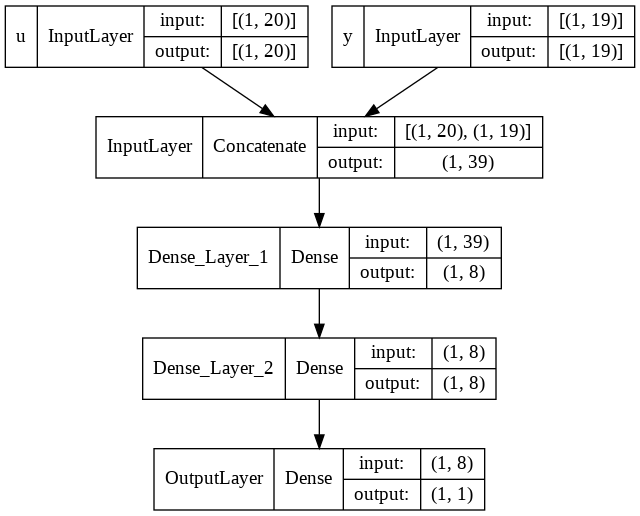

In [13]:
pred_batch_size = 1

u = tf.keras.layers.Input(shape=(K), batch_size=pred_batch_size, name='u')
y = tf.keras.layers.Input(shape=(H-1), batch_size=pred_batch_size, name='y')

concatenate = tf.keras.layers.concatenate([u, y], name='InputLayer', axis=-1)

for i in range(L):
    if i == 0:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(concatenate)
    else:
        layer = tf.keras.layers.Dense(units=A[i],
                                      activation="tanh",
                                      name=f'Dense_Layer_{i+1}')(layer)

outputs = tf.keras.layers.Dense(1, activation='linear', name='OutputLayer')(layer)

prediction_model = tf.keras.Model(inputs=[u, y], outputs=outputs, name='NARX')
prediction_model.summary()


tf.keras.utils.plot_model(prediction_model, show_shapes=True)

Take the weights from the just trained model:

In [30]:
prediction_model.load_weights(filename, by_name=True, skip_mismatch=False)

In [14]:
prediction_model.load_weights('/content/model.06-5.27e-04.h5', by_name=False, skip_mismatch=False)

The following method is used to plot model predictions vs. ground truth, with some additional metrics as MSE and MAE.

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.offsetbox import AnchoredText

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    anchored_text = AnchoredText('MSE:' + str(round(MSE, 6)) + '\n' + 'MAE:' + str(round(MAE, 6)), loc=2)
    ax1.add_artist(anchored_text)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

### *Series-Parallel* Architecture Prediction (Open Loop):

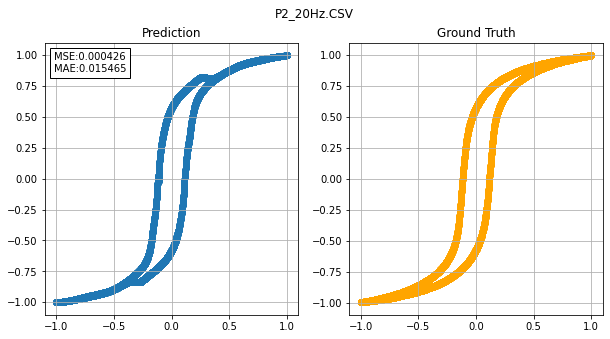

In [18]:
predictions = prediction_model.predict(val_data)

plot_prediction(predictions, val_dataset['P2_20Hz.CSV']['B'][seq_len - 1:], val_dataset['P2_20Hz.CSV']['H'][seq_len - 1:], 'P2_20Hz.CSV')

### *Parallel* Architecture Prediction (Closed Loop):

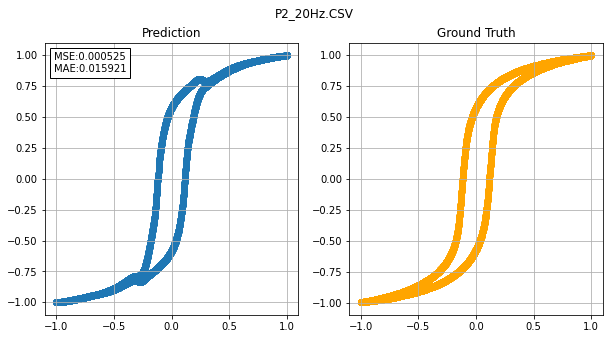

In [17]:
############# DEBUG ###############
## PREDICTIONS OVER VALIDATION DATA #

# Instantiating the Network Input Delay Lines
u = np.zeros((K))
y = np.zeros((H - 1))

# Testing the model on the validation data
model_predictions = {}

for freq in val_dataset:
    signals = {}
    B_pred = []

    H_true = np.array(val_dataset[freq][['H']])
    B_true = np.array(val_dataset[freq][['B']])

    u = H_true[:K]
    y = B_true[:H - 1]

    for i in range(K, len(H_true)):
        prediction = prediction_model.predict([np.expand_dims(u, axis=0), np.expand_dims(y, axis=0)])

        # Rotating the circular buffers after each prediction
        u[:-1] = u[1:]
        u[-1] = H_true[i]
        
        y[:-1] = y[1:]
        y[-1] = prediction

        B_pred.append(prediction)
        
    # Reshape batch predictions into a single array
    B_pred = np.array(B_pred).reshape(-1, 1)

    signals['B_pred'] = B_pred.tolist()
    signals['B_true'] = B_true.tolist()
    signals['H'] = H_true.tolist()

    # Store predictions into a dict to be written as a file
    model_predictions[freq] = signals
    
    plot_prediction(B_pred, B_true[seq_len:], H_true[seq_len:], freq)

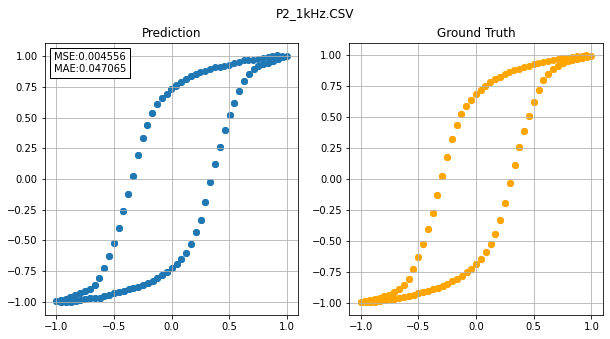

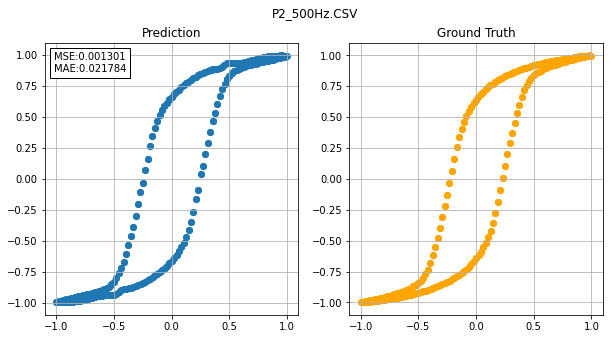

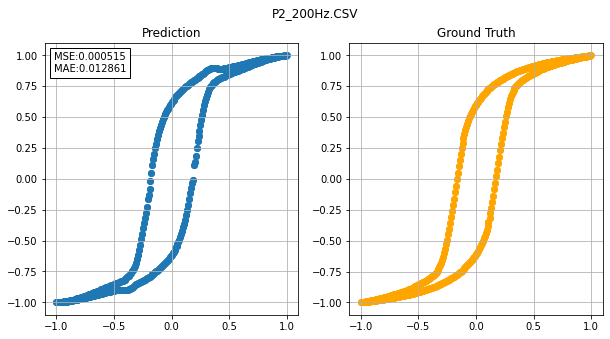

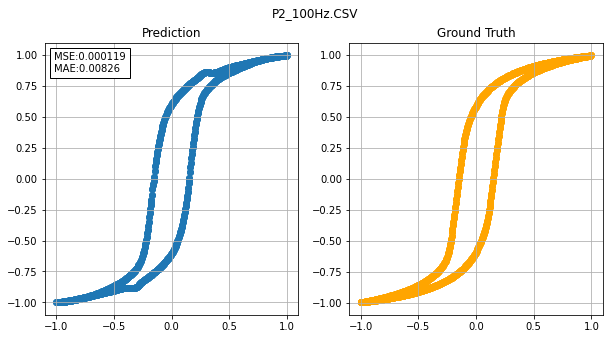

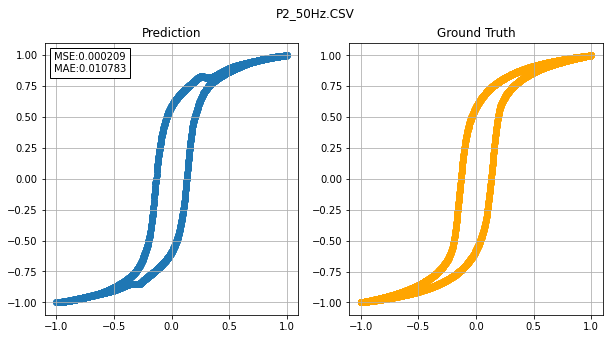

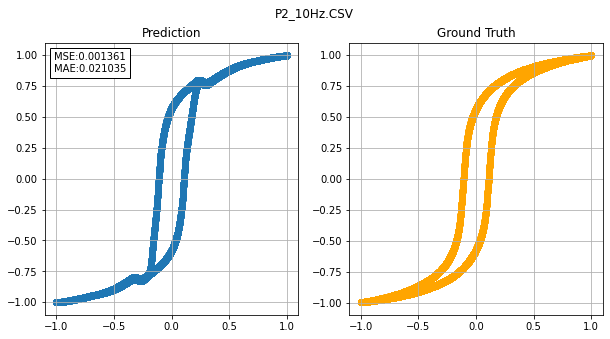

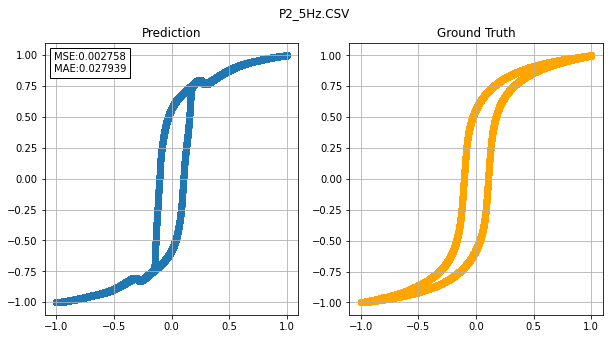

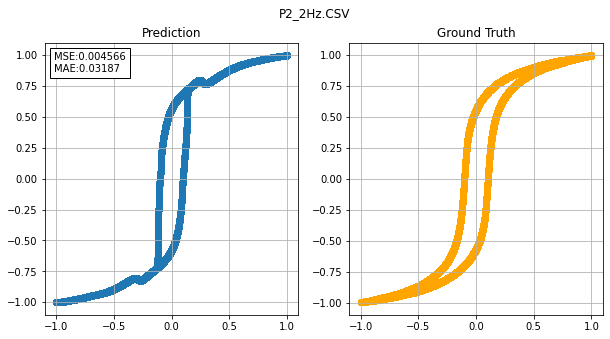

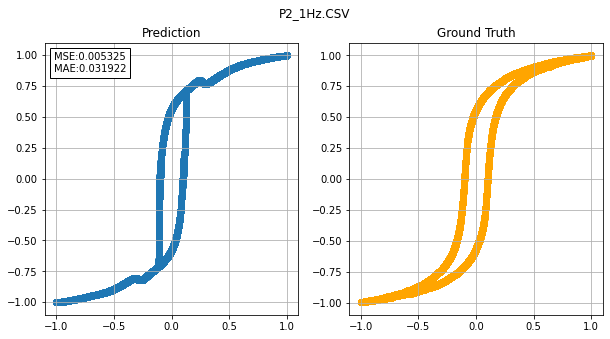

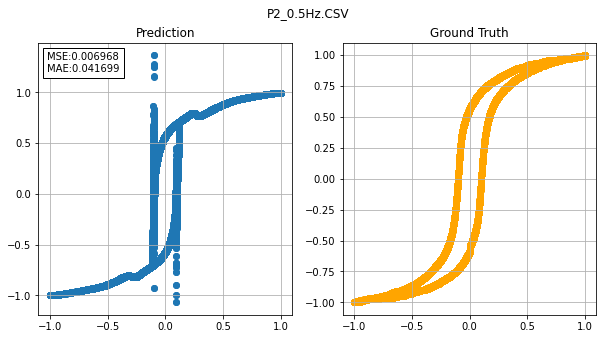

In [16]:
############# DEBUG ###############
## PREDICTIONS OVER TRAIN DATA #

# Instantiating the Network Input Delay Lines
u = np.zeros((K))
y = np.zeros((H - 1))

model_predictions = {}

for freq in reversed(train_dataset): 
    signals = {}
    B_pred = []

    H_true = np.array(train_dataset[freq][['H']])
    B_true = np.array(train_dataset[freq][['B']])

    u = H_true[:K]
    y = B_true[:H - 1]

    for i in range(K, len(H_true)):
        prediction = prediction_model.predict([np.expand_dims(u, axis=0), np.expand_dims(y, axis=0)])

        # Rotating the circular buffers after each prediction
        u[:-1] = u[1:]
        u[-1] = H_true[i]

        y[:-1] = y[1:]
        y[-1] = prediction

        B_pred.append(prediction)
        
    # Reshape batch predictions into a single array
    B_pred = np.array(B_pred).reshape(-1, 1)

    signals['B_pred'] = B_pred.tolist()
    signals['B_true'] = B_true.tolist()
    signals['H'] = H_true.tolist()

    # Store predictions into a dict to be written as a file
    model_predictions[freq] = signals
    
    plot_prediction(B_pred, B_true[seq_len:], H_true[seq_len:], freq)

In [33]:
filename = 'Jordan-P_K=20_H=20_layers=2_neurons=[8, 8]'

In [ ]:
# Write training prediction file and save    
with open(filename + '_training_predictions.txt', 'w') as file:
     file.write(json.dumps(model_predictions))

files.download(filename + '_training_predictions.txt')